In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install 'transformers==4.2.2'
!pip install sentencepiece
!pip3 install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install deberta
!pip install translators
!pip insntall nltk

### **Toward Consistent, Verifiable, and Coherent Commonsense Reasoning in Large LMs**

This notebook provides source code for our two papers in Findings of EMNLP 2021:


1.  Shane Storks, Qiaozi Gao, Yichi Zhang, and Joyce Y. Chai (2021). *Tiered Reasoning for Intuitive Physics: Toward Verifiable Commonsense Language Understanding.* Findings of EMNLP 2021.
2.   Shane Storks and Joyce Y. Chai (2021). *Beyond the Tip of the Iceberg: Assessing Coherence of Text Classifiers.* Findings of EMNLP 2021.

*If you have any questions or problems, please open an issue on our [GitHub repo](https://github.com/sled-group/Verifiable-Coherent-NLU) or email Shane Storks.*

***First, configure the execution mode by selecting a few settings (expand cell if needed):***


   0. (Colab only) Insert the path in your Google Drive to the folder where this notebook is located.

In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/Verifiable-Coherent-NLU-main/'

1.   Model type (choose from BERT large, RoBERTa large, RoBERTa large + MNLI, DeBERTa base, and DeBERTa large).






In [ ]:
# mode = 'bert' # BERT large
mode = 'roberta' # RoBERTa large
# mode = 'roberta_mnli' # RoBERTa large pre-trained on MNLI
# mode = 'deberta' # DeBERTa base for training on TRIP
# mode = 'deberta_large' # DeBERTa large for training on CE and ART

2.   Name of the task we want to train or evaluate on. Set `debug` to `True` to run quick training/evaluation jobs on only a small amount of data.

In [ ]:
task_name = 'trip'
# task_name = 'ce'
# task_name = 'art'

debug = False

3.   (If training models) Training batch size, learning rate, and maximum number of epochs. Settings for results in the paper are provided as examples.

In [ ]:
config_batch_size = 1
config_lr = 1e-5 # Selected learning rate for best RoBERTa-based model in TRIP paper
config_epochs = 5 #10

4.   (For training TRIP models only) Configure the loss weighting scheme for training models here. We provide the 4 modes from the paper as examples.


In [ ]:
# Loss weights for (attributes, preconditions, effects, conflicts, story choices)
if task_name != 'trip':
  print("We do not need a loss weighting scheme for %s dataset. Ignoring this cell." % task_name)
# loss_weights = [0.0, 0.4, 0.4, 0.1, 0.1] # "All losses"
loss_weights = [0.0, 0.4, 0.4, 0.2, 0.0] # "Omit story choice loss"
# loss_weights = [0.0, 0.4, 0.4, 0.0, 0.2] # "Omit conflict detection loss"
# loss_weights = [0.0, 0.0, 0.0, 0.5, 0.5] # "Omit state classification losses"

   5. (If evaluating models) Provide the name of the pre-trained model directory here. This should be the name of a directory within the *saved_models* directory, which should be located where this notebook is. Names of provided pre-trained model directories are listed.

In [ ]:
# TRIP, all losses
# eval_model_dir = 'bert-large-uncased_cloze_1_5e-06_4_0.0-0.4-0.4-0.1-0.1_tiered_pipeline_ablate_attributes_states-logits'
# eval_model_dir = 'roberta-large_cloze_1_1e-05_7_0.0-0.4-0.4-0.1-0.1_tiered_pipeline_ablate_attributes_states-logits'
# eval_model_dir = 'microsoft-deberta-base_cloze_1_5e-06_5_0.0-0.4-0.4-0.1-0.1_tiered_pipeline_ablate_attributes_states-logits'

# TRIP, no story classification loss
# eval_model_dir = 'bert-large-uncased_cloze_1_5e-05_8_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_ablate_attributes_states-logits'
eval_model_dir = 'roberta-large_cloze_1_1e-05_5_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits' # Best model trained in the TRIP paper
# eval_model_dir = 'microsoft-deberta-base_cloze_1_5e-05_5_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_ablate_attributes_states-logits'

# TRIP, no conflict detection loss
# eval_model_dir = 'bert-large-uncased_cloze_1_1e-06_1_0.0-0.4-0.4-0.0-0.2_tiered_pipeline_ablate_attributes_states-logits'
# eval_model_dir = 'roberta-large_cloze_1_5e-06_8_0.0-0.4-0.4-0.0-0.2_tiered_pipeline_ablate_attributes_states-logits'
# eval_model_dir = 'microsoft-deberta-base_cloze_1_1e-06_3_0.0-0.4-0.4-0.0-0.2_tiered_pipeline_ablate_attributes_states-logits'

# TRIP, no physical state classification loss
# eval_model_dir = 'bert-large-uncased_cloze_1_1e-05_3_0.0-0.0-0.0-0.5-0.5_tiered_pipeline_ablate_attributes_states-logits'
# eval_model_dir = 'roberta-large_cloze_1_1e-06_7_0.0-0.0-0.0-0.5-0.5_tiered_pipeline_ablate_attributes_states-logits'
# eval_model_dir = 'microsoft-deberta-base_cloze_1_5e-06_9_0.0-0.0-0.0-0.5-0.5_tiered_pipeline_ablate_attributes_states-logits'

# CE
# eval_model_dir = 'bert-large-uncased_ConvEnt_32_7.5e-06_7_xval'
# eval_model_dir = 'roberta-large_ConvEnt_32_7.5e-06_9_xval'
# eval_model_dir = 'roberta-large-mnli_ConvEnt_32_7.5e-06_7_xval'
# eval_model_dir = 'microsoft-deberta-large_ConvEnt_16_1e-05_9_xval'

# ART
# eval_model_dir = 'bert-large-uncased_art_64_5e-06_8'
# eval_model_dir = 'roberta-large_art_64_2.5e-06_4'
# eval_model_dir = 'DeBERTa-deberta-large_art_32_1e-06_8'

**For more configuration options, scroll down to the Train Models > Configure Hyperparameters cell for the task you're working on.**

# Setup
Run this block every time when starting up the notebook. It will get Colab ready, preprocess the data, and load model packages and classes we'll need later. May take several minutes to run for the first time.

**If you get a `ModuleNotFoundError` for the `www` code base, try the following:**


1.   Ensure the DRIVE_PATH is set properly above.
2.   (Colab only) Verify that this notebook has access to your Google Drive (click the folder icon on the left and then the Google Drive icon).
2.   Try to restart the runtime and refresh your browser window.
2.   (Colab only) If the problem persists, revoke access to Google Drive and re-enable it.





## Colab Setup

Enable auto reloading of code libraries from Google Drive, set up connection to Google Drive, and import some packages. 🔌

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import json
import sys
import torch
import random
import numpy as np
import spacy
!pip install jsonlines

sys.path.append(DRIVE_PATH)

## Model Setup

Next, we'll load up the transformer model, tokenizer, etc. ⏳

### Install HuggingFace transformers and other dependencies

In [ ]:
# !pip install 'transformers==4.2.2'
# !pip install sentencepiece
# !pip3 install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
# !pip install deberta
# !pip install translators

### Get Model Components

Specify which model parameters from transformers we want to use:

In [ ]:
if task_name in ['trip', 'ce']:
  multiple_choice = False
elif task_name == 'art':
  multiple_choice = True
else:
  raise ValueError("Task name should be set to 'trip', 'ce', or 'art' in the first cell of the notebook!")

if mode == 'bert':
  model_name = 'bert-large-uncased'
elif mode == 'roberta':
  model_name = 'roberta-large'
elif mode == 'roberta_mnli':
  model_name = 'roberta-large-mnli'
elif mode == 'deberta':
  model_name = 'microsoft/deberta-base'
elif mode == 'deberta_large':
  model_name = 'microsoft/deberta-large'

Load the tokenizer:

In [ ]:
from transformers import BertTokenizer, RobertaTokenizer, DebertaTokenizer, AlbertTokenizer, T5Tokenizer, GPT2Tokenizer

from DeBERTa import deberta
if mode in ['bert']:
  tokenizer_class = BertTokenizer
elif mode in ['roberta', 'roberta_mnli']:
  tokenizer_class = RobertaTokenizer
elif mode in ['deberta', 'deberta_large']:
  tokenizer_class = DebertaTokenizer

tokenizer = tokenizer_class.from_pretrained(model_name, 
                                                do_lower_case = False, 
                                                cache_dir=os.path.join(DRIVE_PATH, 'cache'))

Load the model and optimizer:



In [ ]:
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, DebertaForSequenceClassification, AlbertForSequenceClassification, AdamW
from transformers import BertForMultipleChoice, RobertaForMultipleChoice, AlbertForMultipleChoice, DebertaModel
from transformers import BertModel, RobertaModel, AlbertModel, DebertaModel, T5Model, T5EncoderModel, GPT2Model
from transformers import RobertaForMaskedLM
from transformers import BertConfig, RobertaConfig, DebertaConfig, AlbertConfig, T5Config, GPT2Config
from www.model.transformers_ext import DebertaForMultipleChoice
from torch.optim import Adam
if not multiple_choice:
  if mode == 'bert':
    model_class = BertForSequenceClassification
    config_class = BertConfig
    emb_class = BertModel
  elif mode in ['roberta', 'roberta_mnli']:
    model_class = RobertaForSequenceClassification
    config_class = RobertaConfig
    emb_class = RobertaModel
    lm_class = RobertaForMaskedLM
  elif mode in ['deberta', 'deberta_large']:
    model_class = DebertaForSequenceClassification
    config_class = DebertaConfig
    emb_class = DebertaModel
else:
  if mode == 'bert':
    model_class = BertForMultipleChoice
    config_class = BertConfig
    emb_class = BertModel    
  elif mode in ['roberta', 'roberta_mnli']:
    model_class = RobertaForMultipleChoice
    config_class = RobertaConfig
    emb_class = RobertaModel
    lm_class = RobertaForMaskedLM
  elif mode in ['deberta', 'deberta_large']:
    model_class = DebertaForMultipleChoice
    config_class = DebertaConfig
    emb_class = DebertaModel

## Data Setup

Preprocess the dataset.

### Preprocessing

Construct the dataset from the .txt files collected from AMT. Save a backup copy in Drive.

In [ ]:
from www.utils import print_dict

partitions = ['train', 'dev', 'test']
subtasks = ['cloze', 'order']

# We can split the data into multiple json files later
data_file = os.path.join(DRIVE_PATH, 'all_data/www.json')
with open(data_file, 'r') as f:
  dataset = json.load(f)

print('Preprocessed examples:')
for ex_idx in [0,1,5,10]:
  ex = dataset['dev'][list(dataset['dev'].keys())[ex_idx]]
  print_dict(ex)

Preprocessed examples:
{
  story_id: 
    13,
  worker_id: 
    A32W24TWSWXW,
  type: 
    None,
  idx: 
    None,
  aug: 
    False,
  actor: 
    John,
  location: 
    kitchen,
  objects: 
    cabinet, counter, knife, pan, potato, pizza,
  sentences: 
    [
      John was getting the snacks ready for the party.
      John opened the cabinet, took out a pan and put it on the counter.
      John opened the fridge and got out the pizza.
      John put the pizza on the pan and put them into the oven.
      John took a knife and cut the hot pizza in eight slices.
    ],
  length: 
    5,
  example_id: 
    13,
  plausible: 
    True,
  breakpoint: 
    -1,
  confl_sents: 
    [],
  confl_pairs: 
    [],
  states: 
    [
      {'h_location': [['John', 0]], 'conscious': [['John', 2]], 'wearing': [['John', 0]], 'h_wet': [['John', 0]], 'hygiene': [['John', 0]], 'location': [['snacks', 0], ['party', 0]], 'exist': [['snacks', 4], ['party', 2]], 'clean': [['snacks', 0], ['party', 0]], 'power': 

### Data Filtering and Sampling
Since there is a big imbalance between plausible/implausible class labels, we will upsample the plausible stories.

For now, we will also break the dataset into two sub-datasets: cloze and ordering.



In [ ]:
cloze_dataset = {p: [] for p in dataset}
order_dataset = {p: [] for p in dataset}

for p in dataset:
  for exid in dataset[p]:
    ex = dataset[p][exid]

    if ex['type'] == None:
      continue
    
    ex_plaus = dataset[p][str(ex['story_id'])]

    if ex['type'] == 'cloze':
      cloze_dataset[p].append(ex)
      cloze_dataset[p].append(ex_plaus) # For every implausible story, add a copy of its corresponding plausible story

    # Exclude augmented ordering examples from dev and test, since the breakpoints aren't always accurate in those
    elif ex['type'] == 'order' and not (p != 'train' and ex['aug']): 
      order_dataset[p].append(ex)
      order_dataset[p].append(ex_plaus)



### Convert TRIP to Two-Story Classification Task

Ready the TRIP dataset for two-story classification.

In [ ]:
from www.utils import print_dict
import json
from collections import Counter

data_file = os.path.join(DRIVE_PATH, 'all_data/www_2s_new.json')
with open(data_file, 'r') as f:
  cloze_dataset_2s, order_dataset_2s = json.load(f)  

#### Apply Data Augmentation

In [ ]:
import translators as ts
from tqdm.notebook import tqdm
from nlp_aug.eda import eda
import nltk; nltk.download('wordnet')
back_trans_dataset = []

for i in tqdm(range(len(cloze_dataset_2s['train']))):
  tmp_data = cloze_dataset_2s['train'][i]
  example_id = tmp_data['example_id'].split('-')
  new_exm_id = "".join([example_id[0],"-T",example_id[1]])
  sentences = tmp_data['stories'][0]['sentences'].copy()
  for sent_idx in tmp_data['confl_pairs'][0]:
    sentences[sent_idx] = ts.google(ts.sogou(sentences[sent_idx], from_language='en', to_language='es'), from_language='es', to_language='en')
  if sentences==tmp_data['stories'][0]['sentences']:
    continue
  tmp_data['stories'][0]['sentences'] = sentences
  tmp_data['example_id'] = new_exm_id
  tmp_data['stories'][0]['example_id'] = new_exm_id
  back_trans_dataset.append(tmp_data)

for i in tqdm(range(len(cloze_dataset_2s['train']))):
  for k in range(3):
    tmp_data = cloze_dataset_2s['train'][i]
    example_id = tmp_data['example_id'].split('-')
    new_exm_id = "".join([example_id[0],"-E",example_id[1]])
    sentences = tmp_data['stories'][0]['sentences'].copy()
    for sent_idx in range(tmp_data['length']):
      sentences[sent_idx] =  eda(sentences[sent_idx], alpha_sr=0.4, alpha_ri=0.1, alpha_rs=0.05, p_rd=0.05, num_aug=3)[k].capitalize()
    if sentences==tmp_data['stories'][0]['sentences']:
      continue
    tmp_data['stories'][0]['sentences'] = sentences
    tmp_data['example_id'] = new_exm_id
    tmp_data['stories'][0]['example_id'] = new_exm_id
    back_trans_dataset.append(tmp_data)

json_string = json.dumps(back_trans_dataset)
with open(os.path.join(DRIVE_PATH, 'all_data/back_trans_dataset.json'), 'w') as f:
    json.dump(json_string, f)
cloze_dataset_2s['train'] += back_trans_dataset

Using United States server backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

In [ ]:
# data_file = os.path.join(DRIVE_PATH, 'all_data/back_trans_dataset.json')
# with open(data_file, 'r') as f:
#   back_trans_dataset = json.load(f) 
# back_trans_dataset = json.loads(back_trans_dataset)
# cloze_dataset_2s['train'] += back_trans_dataset 

In [ ]:
for p in cloze_dataset_2s:
  label_dist = Counter([ex['label'] for ex in cloze_dataset_2s[p]])
  print('Cloze label distribution (%s):' % p)
  print(label_dist.most_common())
print_dict(cloze_dataset_2s['train'][0])

Cloze label distribution (train):
[(1, 1999), (0, 1995)]
Cloze label distribution (dev):
[(0, 161), (1, 161)]
Cloze label distribution (test):
[(1, 176), (0, 175)]
{
  example_id: 
    0-EEETC0,
  stories: 
    [
      {'story_id': 0, 'worker_id': 'A1F01FVEPYCPHO', 'type': 'cloze', 'idx': 0, 'aug': False, 'actor': 'Tom', 'location': 'kitchen', 'objects': 'dustbin, microwave, pan, plate, cereal, soup', 'sentences': ['Dustbin bought tomcat a new tom for the kitchen', 'Tom turkey threw shell broken a the in ash bin', 'Tom from some soup have have got the fridge', 'Tom assign the soup in the zap oven', 'Tom total total comed the cold soup'], 'length': 5, 'example_id': '0-EEETC0', 'plausible': False, 'breakpoint': 4, 'confl_sents': [3], 'confl_pairs': [[3, 4]], 'states': [{'h_location': [['Tom', 0]], 'conscious': [['Tom', 2]], 'wearing': [['Tom', 0]], 'h_wet': [['Tom', 0]], 'hygiene': [['Tom', 0]], 'location': [['dustbin', 6]], 'exist': [['dustbin', 4]], 'clean': [['dustbin', 0]], 'power': 

---

# TRIP Results

Contains code for the tiered and random TRIP baselines.

In [ ]:
if task_name != 'trip':
  raise ValueError('Please configure task_name in first cell to "trip" to run TRIP results!')

## Random Tiered Classifier for TRIP

For the random baseline, we average the results of 10 runs. Running the below will report (mean, variance) for each evaluation partition.

In [ ]:
from www.dataset.prepro import get_tiered_data
from www.dataset.featurize import add_bert_features_tiered, get_tensor_dataset_tiered
from collections import Counter
import numpy as np
from www.dataset.ann import att_to_num_classes, idx_to_att
from sklearn.metrics import accuracy_score, f1_score
from www.utils import print_dict

tiered_dataset = cloze_dataset_2s

seq_length = 16 # Max sequence length to pad to

tiered_dataset = get_tiered_data(tiered_dataset)
tiered_dataset = add_bert_features_tiered(tiered_dataset, tokenizer, seq_length, add_segment_ids=True)

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


In [ ]:
from www.dataset.prepro import get_tiered_data, balance_labels
from www.dataset.featurize import add_bert_features_tiered, get_tensor_dataset_tiered
from collections import Counter
import numpy as np
from www.dataset.ann import att_to_num_classes, idx_to_att, att_default_values
from sklearn.metrics import accuracy_score, f1_score
from www.utils import print_dict
import numpy as np

# Have to add BERT input IDs and tensorize again
num_runs = 10
stories = []
pred_stories = []
conflicts = []
pred_conflicts = []
preconditions = []
pred_preconditions = []
effects = []
pred_effects = []
verifiability = []
consistency = []
for p in tiered_dataset:
  if p == 'train':
    continue
  metr_avg = {}
  print('starting %s...' % p)
  for r in range(num_runs):
    print('starting run %s...' % str(r))
    for ex in tiered_dataset[p]:
      verifiable = True
      consistent = True

      stories.append(ex['label'])
      pred_stories.append(np.random.randint(2))

      if stories[-1] != pred_stories[-1]:
        verifiable = False

      labels_ex_p = []
      preds_ex_p = []

      labels_ex_e = []
      preds_ex_e = []

      labels_ex_c = []
      preds_ex_c = []

      for si, story in enumerate(ex['stories']):
        labels_story_p = []
        preds_story_p = []

        labels_story_e = []
        preds_story_e = []      

        for ent_ann in story['entities']:
          entity = ent_ann['entity']

          if si == 1 - ex['label']:
            labels_ex_c.append(ent_ann['conflict_span_onehot'])
            pred = np.zeros(ent_ann['conflict_span_onehot'].shape)
            for cs in np.random.choice(len(pred), size=2, replace=False):
              pred[cs] = 1
            preds_ex_c.append(pred)

          labels_ent = []
          preds_ent = []
          for s, sent_ann in enumerate(ent_ann['preconditions']):
            if s < len(story['sentences']):
              if entity in story['sentences'][s]:

                labels_ent.append(sent_ann)
                sent_ann_pred = []
                for i, l in enumerate(sent_ann):
                  pl = np.random.randint(att_to_num_classes[idx_to_att[i]])
                  if pl > 0 and pl != att_default_values[idx_to_att[i]]:
                    if pl != l:
                      verifiable = False
                  sent_ann_pred.append(pl)
                preds_ent.append(sent_ann_pred)

          labels_story_p.append(labels_ent)
          preds_story_p.append(preds_ent)

          labels_ent = []
          preds_ent = []
          for s, sent_ann in enumerate(ent_ann['effects']):
            if s < len(story['sentences']):
              if entity in story['sentences'][s]:
    
                labels_ent.append(sent_ann)
                sent_ann_pred = []
                for i, l in enumerate(sent_ann):
                  pl = np.random.randint(att_to_num_classes[idx_to_att[i]])
                  if pl > 0 and pl != att_default_values[idx_to_att[i]]:
                    if pl != l:
                      verifiable = False
                  sent_ann_pred.append(pl)
                preds_ent.append(sent_ann_pred)

          labels_story_e.append(labels_ent)
          preds_story_e.append(preds_ent)

        labels_ex_p.append(labels_story_p)
        preds_ex_p.append(preds_story_p)

        labels_ex_e.append(labels_story_e)
        preds_ex_e.append(preds_story_e)

      conflicts.append(labels_ex_c)
      pred_conflicts.append(preds_ex_c)

      preconditions.append(labels_ex_p)
      pred_preconditions.append(preds_ex_p)

      effects.append(labels_ex_e)
      pred_effects.append(preds_ex_e)

      p_confl = np.nonzero(np.sum(np.array(preds_ex_c), axis=0))[0]
      l_confl = np.nonzero(np.sum(np.array(labels_ex_c), axis=0))[0]
      assert len(l_confl) == 2, str(labels_ex_c)
      if not (p_confl[0] == l_confl[0] and p_confl[1] == l_confl[1]):
        verifiable = False    
        consistent = False

      verifiability.append(1 if verifiable else 0)
      consistency.append(1 if consistent else 0)

    # Compute metrics
    metr = {}
    metr['story_accuracy'] = accuracy_score(stories, pred_stories)

    conflicts_flat = [c for c_ex in conflicts for c_ent in c_ex for c in c_ent]
    pred_conflicts_flat = [c for c_ex in pred_conflicts for c_ent in c_ex for c in c_ent]
    metr['confl_f1'] = f1_score(conflicts_flat, pred_conflicts_flat, average='macro')

    preconditions_flat = [p for p_ex in preconditions for p_story in p_ex for p_sent in p_story for p_ent in p_sent for p in p_ent]
    pred_preconditions_flat = [p for p_ex in pred_preconditions for p_story in p_ex for p_sent in p_story for p_ent in p_sent for p in p_ent]
    metr['precondition_f1'] = f1_score(preconditions_flat, pred_preconditions_flat, average='macro')

    effects_flat = [p for p_ex in effects for p_story in p_ex for p_sent in p_story for p_ent in p_sent for p in p_ent]
    pred_effects_flat = [p for p_ex in pred_effects for p_story in p_ex for p_sent in p_story for p_ent in p_sent for p in p_ent]
    metr['effect_f1'] = f1_score(effects_flat, pred_effects_flat, average='macro')

    metr['verifiability'] = np.mean(verifiability)
    metr['consistency'] = np.mean(consistency)

    for k in metr:
      if k not in metr_avg:
        metr_avg[k] = []
      metr_avg[k].append(metr[k])

  for k in metr_avg:
    metr_avg[k] = (np.mean(metr_avg[k]), np.var(metr_avg[k]) ** 0.5)
  print('RANDOM BASELINE (%s, %s runs)' % (str(p), str(num_runs)))
  print_dict(metr_avg)

starting dev...
starting run 0...
starting run 1...
starting run 2...
starting run 3...
starting run 4...
starting run 5...
starting run 6...
starting run 7...
starting run 8...
starting run 9...
RANDOM BASELINE (dev, 10 runs)
{
  story_accuracy: 
    (0.5092834960070984, 0.01691152446481327),
  confl_f1: 
    (0.48773050572611637, 0.0014246537290093504),
  precondition_f1: 
    (0.04019496346834568, 6.644146975335546e-05),
  effect_f1: 
    (0.04043233245795723, 7.944811698290608e-05),
  verifiability: 
    (0.0, 0.0),
  consistency: 
    (0.119647047224687, 0.00414486989006416),
}


starting test...
starting run 0...
starting run 1...
starting run 2...
starting run 3...
starting run 4...
starting run 5...
starting run 6...
starting run 7...
starting run 8...
starting run 9...
RANDOM BASELINE (test, 10 runs)
{
  story_accuracy: 
    (0.497709256749358, 0.0013326983265705224),
  confl_f1: 
    (0.48490360829104, 0.0003008836712387868),
  precondition_f1: 
    (0.04000053896066595, 5.21

## Transformer-Based Tiered Classifier for TRIP

This is the baseline model presented in the paper. Based on the settings above, the below cells can be used for training and evaluating models.


### Featurization for Tiered Classification

Get the data ready for input to the model.

In [ ]:
from www.dataset.prepro import get_tiered_data, balance_labels
from www.dataset.featurize import add_bert_features_tiered, get_tensor_dataset_tiered
from collections import Counter

tiered_dataset = cloze_dataset_2s

# Debug the code on a small amount of data
if debug:
  for k in tiered_dataset:
    tiered_dataset[k] = tiered_dataset[k][:20]

# train_spans = True
train_spans = False
if train_spans:
  tiered_dataset = get_story_spans_2s(tiered_dataset, train_only=True)
  tiered_dataset['train'] = [ex for ex in tiered_dataset['train'] if ex['label'] != -1] # For now, ignore examples where both stories are plausible :(

seq_length = 16 # Max sequence length to pad to

tiered_dataset = get_tiered_data(tiered_dataset)
tiered_dataset = add_bert_features_tiered(tiered_dataset, tokenizer, seq_length, add_segment_ids=True)

tiered_tensor_dataset = {}
max_story_length = max([len(ex['stories'][0]['sentences']) for p in tiered_dataset for ex in tiered_dataset[p]])
for p in tiered_dataset:
  tiered_tensor_dataset[p] = get_tensor_dataset_tiered(tiered_dataset[p], max_story_length, add_segment_ids=True)

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


### Train Models

#### Configure Hyperparameters
We will perform grid search over (batch size, learning rate). Configure the training sub-task, search space and set the maximum number of training epochs here. Currently configured for re-training the best RoBERTa-based model instance. Read code comments for more information.

**Additional configuration options:**
* Change the `generate_learning_curve` variable to `True` to generate data for training curves in the style presented in the paper.
* You may ablate the input to the Conflict Detector based on a few pre-defined ablation modes. To do so, change the `ablation` variable based on the comments in the code.

In [ ]:
from www.dataset.ann import att_to_idx, att_to_num_classes, att_types

subtask = 'cloze'
batch_sizes = [config_batch_size]
learning_rates = [config_lr]
epochs = config_epochs
eval_batch_size = 16
generate_learning_curve =  True # Generate data for training curve figure in TRIP paper

num_state_labels = {}
for att in att_to_idx:
  if att_types[att] == 'default':
    num_state_labels[att_to_idx[att]] = 3
  else:
    num_state_labels[att_to_idx[att]] = att_to_num_classes[att] # Location attributes fall into this since they don't have well-define pre- and post-condition yet

# Ablation options:
# - attributes: skip attribute prediction phase
# - embeddings: DON'T input contextual embeddings to conflict detector
# - states: DON'T input states to conflict detector
# - states-labels: in states input to conflict detector, include predicted labels
# - states-logits: in states input to conflict detector, include state logits (preferred)
# - states-teacher-forcing: train conflict detector on ground truth state labels (not predictions)
# - states-attention: re-weight input to conflict detector with weights conditioned on states representation
ablation = ['attributes', 'states-logits'] # This is the default mode presented in the paper

#### Perform Grid Search

Perform hyperparameter tuning to find the best story classification model.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from www.model.train import train_epoch_tiered
from www.model.eval import evaluate_tiered, save_results, save_preds, add_entity_attribute_labels
from sklearn.metrics import accuracy_score, f1_score
from www.utils import print_dict, get_model_dir
from www.model.transformers_ext import TieredModelPipeline
from www.dataset.ann import att_to_num_classes
import shutil
import pandas as pd

seed_val = 22 # Save random seed for reproducibility
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll keep the validation data here with a constant eval batch size
dev_sampler = SequentialSampler(tiered_tensor_dataset['dev'])
dev_dataloader = DataLoader(tiered_tensor_dataset['dev'], sampler=dev_sampler, batch_size=eval_batch_size)
dev_dataset_name = subtask + '_%s_dev'
dev_ids = [ex['example_id'] for ex in tiered_dataset['dev']]

all_losses = []
param_combos = []
combo_names = []
all_val_objs = []
output_dirs = []
best_obj = 0.0
best_model = '<none>'
best_dir = ''
best_obj2 = 0.0
best_model2 = '<none>'
best_dir2 = ''

print('Beginning grid search for the %s sub-task over %s parameter combination(s)!' % (subtask, str(len(batch_sizes) * len(learning_rates))))
for bs in batch_sizes:
  for lr in learning_rates:
    print('\nTRAINING MODEL: bs=%s, lr=%s' % (str(bs), str(lr)))

    loss_values = []
    obj_values = []

    # Set up training dataset with new batch size
    train_sampler = RandomSampler(tiered_tensor_dataset['train'])
    train_dataloader = DataLoader(tiered_tensor_dataset['train'], sampler=train_sampler, batch_size=bs)

    # Set up model
    config = config_class.from_pretrained(model_name,
                                          cache_dir=os.path.join(DRIVE_PATH, 'cache'))    
    emb = emb_class.from_pretrained(model_name,
                                          config=config,
                                          cache_dir=os.path.join(DRIVE_PATH, 'cache'))    
    if torch.cuda.is_available():
      emb.cuda()
    device = emb.device
    max_story_length = max([len(ex['stories'][0]['sentences']) for p in tiered_dataset for ex in tiered_dataset[p]])
    model = TieredModelPipeline(emb, max_story_length, len(att_to_num_classes), num_state_labels,
                                config_class, model_name, device, 
                                ablation=ablation, loss_weights=loss_weights).to(device)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = total_steps)

    train_lc_data = []
    val_lc_data = []
    for epoch in range(epochs):
      # Train the model for one epoch
      print('[%s] Beginning epoch...' % str(epoch))

      epoch_loss, _ = train_epoch_tiered(model, optimizer, train_dataloader, device, seg_mode=False, 
                                         build_learning_curves=generate_learning_curve, val_dataloader=dev_dataloader, 
                                         train_lc_data=train_lc_data, val_lc_data=val_lc_data)
      
      # Save loss
      loss_values.append(epoch_loss)

      # Validate on dev set
      validation_results = evaluate_tiered(model, dev_dataloader, device, [(accuracy_score, 'accuracy'), (f1_score, 'f1')], seg_mode=False, return_explanations=True)
      metr_attr, all_pred_atts, all_atts, \
      metr_prec, all_pred_prec, all_prec, \
      metr_eff, all_pred_eff, all_eff, \
      metr_conflicts, all_pred_conflicts, all_conflicts, \
      metr_stories, all_pred_stories, all_stories, explanations = validation_results[:16]
      explanations = add_entity_attribute_labels(explanations, tiered_dataset['dev'], list(att_to_num_classes.keys()))

      print('[%s] Validation results:' % str(epoch))
      print('[%s] Preconditions:' % str(epoch))
      print_dict(metr_prec)
      print('[%s] Effects:' % str(epoch))
      print_dict(metr_eff)
      print('[%s] Conflicts:' % str(epoch))
      print_dict(metr_conflicts)
      print('[%s] Stories:' % str(epoch))
      print_dict(metr_stories)

      # Save accuracy - want to maximize verifiability of tiered predictions
      ver = metr_stories['verifiability']
      acc = metr_stories['accuracy']
      obj_values.append(ver)
      
      # Save model checkpoint
      print('[%s] Saving model checkpoint...' % str(epoch))
      model_param_str = get_model_dir(model_name.replace('/', '-'), subtask, bs, lr, epoch) + '_' +  '-'.join([str(lw) for lw in loss_weights]) +  '_tiered_pipeline_lc'
      if train_spans:
        model_param_str += 'spans'
      if len(model.ablation) > 0:
        model_param_str += '_ablate_'
        model_param_str += '_'.join(model.ablation)
      output_dir = os.path.join(DRIVE_PATH, 'saved_models', model_param_str)
      output_dirs.append(output_dir)
      if not os.path.exists(output_dir):
        os.makedirs(output_dir)

      save_results(metr_attr, output_dir, dev_dataset_name % 'attributes')
      save_results(metr_prec, output_dir, dev_dataset_name % 'preconditions')
      save_results(metr_eff, output_dir, dev_dataset_name % 'effects')
      save_results(metr_conflicts, output_dir, dev_dataset_name % 'conflicts')
      save_results(metr_stories, output_dir, dev_dataset_name % 'stories')
      save_results(explanations, output_dir, dev_dataset_name % 'explanations')

      # Just save story preds
      save_preds(dev_ids, all_stories, all_pred_stories, output_dir, dev_dataset_name % 'stories')

      emb = emb.module if hasattr(emb, 'module') else emb
      emb.save_pretrained(output_dir)
      torch.save(model, os.path.join(output_dir, 'classifiers.pth'))
      tokenizer.save_vocabulary(output_dir)

      if ver > best_obj:
        best_obj = ver
        best_model = model_param_str
        best_dir = output_dir
      if acc > best_obj2:
        best_obj2 = acc
        best_model2 = model_param_str
        best_dir2 = output_dir        

      for od in output_dirs:
        if od != best_dir and od != best_dir2 and os.path.exists(od):
          shutil.rmtree(od)

      print('[%s] Finished epoch.' % str(epoch))

    all_losses.append(loss_values)
    all_val_objs.append(obj_values)
    param_combos.append((bs, lr))
    combo_names.append('bs=%s, lr=%s' % (str(bs), str(lr)))

print('Finished grid search! :)')
print('Best validation *verifiability* %s from model %s.' % (str(best_obj), best_model))
print('Best validation *accuracy* %s from model %s.' % (str(best_obj2), best_model2))

if generate_learning_curve:
  print('Saving learning curve data...')
  train_lc_data = [subrecord for record in train_lc_data for subrecord in record] # flatten
  val_lc_data = [subrecord for record in val_lc_data for subrecord in record] # flatten

  train_lc_data = pd.DataFrame(train_lc_data)
  print(os.path.join(best_dir if best_dir != '<none>' else best_dir2, 'learning_curve_data_train.csv'))
  train_lc_data.to_csv(os.path.join(best_dir if best_dir != '' else best_dir2, 'learning_curve_data_train.csv'), index=False)
  val_lc_data = pd.DataFrame(val_lc_data)
  val_lc_data.to_csv(os.path.join(best_dir if best_dir != '' else best_dir2, 'learning_curve_data_val.csv'), index=False)
  print('Learning curve data saved. %s rows saved for training, %s rows saved for validation.' % (str(len(train_lc_data.index)), str(len(val_lc_data.index))))

Beginning grid search for the cloze sub-task over 1 parameter combination(s)!

TRAINING MODEL: bs=1, lr=1e-05


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

[                                                                        ] N/A%

[0] Beginning epoch...


[########################################################################] 100%
[                                                                        ] N/A%

	Beginning evaluation...
		Running prediction...


[########################################################################] 100%


		Computing metrics...
	Finished evaluation in 0:02:04s.
[0] Validation results:
[0] Preconditions:
{
  accuracy: 
    0.994427450614113,
  f1: 
    0.2963158231983965,
  accuracy_0: 
    0.9935553168635876,
  f1_0: 
    0.3322557471264368,
  accuracy_1: 
    0.9995680194274507,
  f1_1: 
    0.6646957546650618,
  accuracy_2: 
    0.9988791855414935,
  f1_2: 
    0.33314642617946205,
  accuracy_3: 
    0.9985989819268668,
  f1_3: 
    0.3330996666355111,
  accuracy_4: 
    0.9996964460841545,
  f1_4: 
    0.3332827333341118,
  accuracy_5: 
    0.9835847382431233,
  f1_5: 
    0.22498292278114176,
  accuracy_6: 
    0.9854294120394153,
  f1_6: 
    0.6291783674477421,
  accuracy_7: 
    0.9982370522579741,
  f1_7: 
    0.3330392494824319,
  accuracy_8: 
    0.9962172512025406,
  f1_8: 
    0.5798498088309979,
  accuracy_9: 
    0.9867954046607201,
  f1_9: 
    0.631793682452645,
  accuracy_10: 
    0.9960187736421799,
  f1_10: 
    0.46174577777246223,
  accuracy_11: 
    0.9971512632512

[                                                                        ] N/A%

[0] Finished epoch.
[1] Beginning epoch...


[########################################################################] 100%
[                                                                        ] N/A%

	Beginning evaluation...
		Running prediction...


[########################################################################] 100%


		Computing metrics...
	Finished evaluation in 0:02:04s.
[1] Validation results:
[1] Preconditions:
{
  accuracy: 
    0.9946364358100219,
  f1: 
    0.4653481695955335,
  accuracy_0: 
    0.9935553168635876,
  f1_0: 
    0.3322557471264368,
  accuracy_1: 
    0.9994629430719656,
  f1_1: 
    0.6642198380442204,
  accuracy_2: 
    0.9988791855414935,
  f1_2: 
    0.33314642617946205,
  accuracy_3: 
    0.9985989819268668,
  f1_3: 
    0.3330996666355111,
  accuracy_4: 
    0.9996964460841545,
  f1_4: 
    0.3332827333341118,
  accuracy_5: 
    0.9855344883949003,
  f1_5: 
    0.3759849049705676,
  accuracy_6: 
    0.9847289030028488,
  f1_6: 
    0.6276227354046733,
  accuracy_7: 
    0.9982370522579741,
  f1_7: 
    0.3330392494824319,
  accuracy_8: 
    0.9969527856909354,
  f1_8: 
    0.5994102058214589,
  accuracy_9: 
    0.9859197683650119,
  f1_9: 
    0.6300416383745446,
  accuracy_10: 
    0.9966609069256993,
  f1_10: 
    0.5357323630507937,
  accuracy_11: 
    0.9981086256012

[                                                                        ] N/A%

[1] Finished epoch.
[2] Beginning epoch...


[########################################################################] 100%
[                                                                        ] N/A%

	Beginning evaluation...
		Running prediction...


[########################################################################] 100%


		Computing metrics...
	Finished evaluation in 0:02:04s.
[2] Validation results:
[2] Preconditions:
{
  accuracy: 
    0.9949551674216598,
  f1: 
    0.47478978880782435,
  accuracy_0: 
    0.9962873021061972,
  f1_0: 
    0.5426683376175476,
  accuracy_1: 
    0.9995680194274507,
  f1_1: 
    0.664701608267439,
  accuracy_2: 
    0.9988791855414935,
  f1_2: 
    0.33314642617946205,
  accuracy_3: 
    0.9985989819268668,
  f1_3: 
    0.3330996666355111,
  accuracy_4: 
    0.9996964460841545,
  f1_4: 
    0.3332827333341118,
  accuracy_5: 
    0.9852776350814926,
  f1_5: 
    0.3863450509330076,
  accuracy_6: 
    0.9857096156540419,
  f1_6: 
    0.6296538611352365,
  accuracy_7: 
    0.9982370522579741,
  f1_7: 
    0.3330392494824319,
  accuracy_8: 
    0.9966959323775276,
  f1_8: 
    0.5937858274848833,
  accuracy_9: 
    0.9869588567692523,
  f1_9: 
    0.631832880597742,
  accuracy_10: 
    0.9966375566244805,
  f1_10: 
    0.5395314993905413,
  accuracy_11: 
    0.99809695045066

[                                                                        ] N/A%

[2] Finished epoch.
[3] Beginning epoch...


[########################################################################] 100%
[                                                                        ] N/A%

	Beginning evaluation...
		Running prediction...


[########################################################################] 100%


		Computing metrics...
	Finished evaluation in 0:02:04s.
[3] Validation results:
[3] Preconditions:
{
  accuracy: 
    0.9948512585812357,
  f1: 
    0.5219667068940191,
  accuracy_0: 
    0.9945126792135619,
  f1_0: 
    0.4234671340612979,
  accuracy_1: 
    0.9996614206323261,
  f1_1: 
    0.6651264031797534,
  accuracy_2: 
    0.9988791855414935,
  f1_2: 
    0.33314642617946205,
  accuracy_3: 
    0.9985989819268668,
  f1_3: 
    0.3330996666355111,
  accuracy_4: 
    0.9996964460841545,
  f1_4: 
    0.3332827333341118,
  accuracy_5: 
    0.9852192593284453,
  f1_5: 
    0.4451927891934647,
  accuracy_6: 
    0.9846822024004109,
  f1_6: 
    0.6268709048777008,
  accuracy_7: 
    0.9982370522579741,
  f1_7: 
    0.3330392494824319,
  accuracy_8: 
    0.9968944099378882,
  f1_8: 
    0.5986827449972525,
  accuracy_9: 
    0.9862349974314669,
  f1_9: 
    0.62989485308724,
  accuracy_10: 
    0.9964857796665577,
  f1_10: 
    0.5381166143723539,
  accuracy_11: 
    0.997688320179330

[                                                                        ] N/A%

[3] Finished epoch.
[4] Beginning epoch...


[########################################################################] 100%
[                                                                        ] N/A%

	Beginning evaluation...
		Running prediction...


[########################################################################] 100%


		Computing metrics...
	Finished evaluation in 0:02:04s.
[4] Validation results:
[4] Preconditions:
{
  accuracy: 
    0.9948816139728203,
  f1: 
    0.5526942222432226,
  accuracy_0: 
    0.9972796899079999,
  f1_0: 
    0.5838676166161515,
  accuracy_1: 
    0.9994512679213562,
  f1_1: 
    0.6641720253203619,
  accuracy_2: 
    0.9988791855414935,
  f1_2: 
    0.33314642617946205,
  accuracy_3: 
    0.9985989819268668,
  f1_3: 
    0.3330996666355111,
  accuracy_4: 
    0.9996964460841545,
  f1_4: 
    0.3332827333341118,
  accuracy_5: 
    0.985289310232102,
  f1_5: 
    0.4795160150947732,
  accuracy_6: 
    0.9843903236351749,
  f1_6: 
    0.6261051030459376,
  accuracy_7: 
    0.9983888292158969,
  f1_7: 
    0.43748221822665206,
  accuracy_8: 
    0.9966025311726521,
  f1_8: 
    0.5880861057167172,
  accuracy_9: 
    0.9858146920095269,
  f1_9: 
    0.6294099981296234,
  accuracy_10: 
    0.9965791808714333,
  f1_10: 
    0.5408099482126123,
  accuracy_11: 
    0.9977700462335

In [ ]:
import pandas as pd
train_curve = pd.read_csv('/content/drive/MyDrive/Verifiable-Coherent-NLU-main/saved_models/roberta-large_cloze_1_1e-05_1_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits/learning_curve_data_train.csv')
val_curve = pd.read_csv('/content/drive/MyDrive/Verifiable-Coherent-NLU-main/saved_models/roberta-large_cloze_1_1e-05_1_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits/learning_curve_data_val.csv')


In [ ]:
from matplotlib import  pyplot as plt 
import numpy as np

(0.0, 0.2)

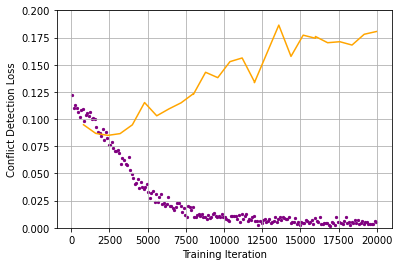

In [ ]:
train_iter = []
train_loss_conflicts = []
for i in range(0, len(train_curve['iteration']), 100):
  train_iter.append(i+50)
  train_loss_conflicts.append(np.mean(train_curve['loss_conflicts'][i:(i+99)]))
iter_idx = val_curve['iteration'][val_curve['iteration']<50000]
iter = val_curve['iteration']<50000
plt.plot(val_curve['iteration'][iter][1:], val_curve['loss_conflicts'][iter][1:], c='orange')
plt.scatter(train_iter, train_loss_conflicts, c='purple', s=5)
plt.grid()
plt.xlabel('Training Iteration')
plt.ylabel('Conflict Detection Loss')
plt.ylim((0,0.2))

(0.0, 0.6)

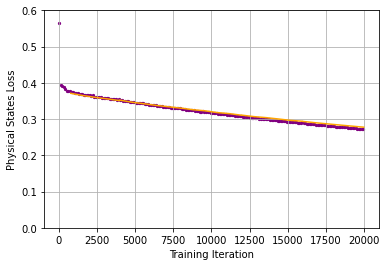

In [ ]:
train_iter = []
train_loss_conflicts = []
for i in range(0, len(train_curve['iteration']), 100):
  train_iter.append(i+50)
  train_loss_conflicts.append(np.mean(train_curve['loss_effects'][i:(i+99)]))
iter_idx = val_curve['iteration'][val_curve['iteration']<20000]
iter = val_curve['iteration']<20000
plt.plot(val_curve['iteration'][iter][1:], val_curve['loss_effects'][iter][1:], c='orange')
plt.scatter(train_iter, train_loss_conflicts, c='purple', s=5)
plt.grid()
plt.xlabel('Training Iteration')
plt.ylabel('Physical States Loss')
plt.ylim((0,0.6))

(0.0, 0.9)

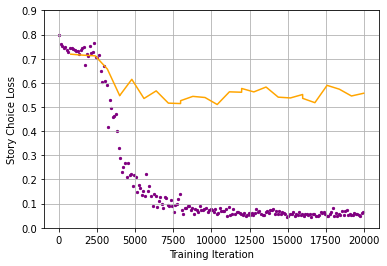

In [ ]:
train_iter = []
train_loss_conflicts = []
for i in range(0, len(train_curve['iteration']), 100):
  train_iter.append(i+50)
  train_loss_conflicts.append(np.mean(train_curve['loss_stories'][i:(i+99)]))
iter_idx = val_curve['iteration'][val_curve['iteration']<20000]
iter = val_curve['iteration']<20000
plt.plot(val_curve['iteration'][iter][1:], val_curve['loss_stories'][iter][1:], c='orange')
plt.scatter(train_iter, train_loss_conflicts, c='purple', s=5)
plt.grid()
plt.xlabel('Training Iteration')
plt.ylabel('Story Choice Loss')
plt.ylim((0,0.9))

Delete all non-best model checkpoints:

In [ ]:
import shutil

# Delete non-best model checkpoints
for od in output_dirs:
  if od != best_dir and od != best_dir2 and os.path.exists(od):
    shutil.rmtree(od)

In [ ]:
print(best_dir)
print(best_dir2)

/content/drive/MyDrive/Verifiable-Coherent-NLU-main/saved_models/roberta-large_cloze_1_1e-05_1_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits
/content/drive/MyDrive/Verifiable-Coherent-NLU-main/saved_models/roberta-large_cloze_1_1e-05_1_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits


### Test Models

Evaluate accuracy, consistency, and verifiability on the test set.

#### Load the Trained Model

Load the trained model we want to probe and select the appropriate dataset. Paths to the pre-trained models presented in the paper are already provided (download links are found in GitHub repo).

In [ ]:
from www.model.transformers_ext import TieredModelPipeline
from www.dataset.ann import att_to_num_classes, att_to_idx, att_types

eval_model_dir = '/content/drive/MyDrive/Verifiable-Coherent-NLU-main/saved_models/roberta-large_cloze_1_1e-05_2_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits'
# eval_model_dir = best_dir
probe_model = eval_model_dir
probe_model = os.path.join(DRIVE_PATH, 'saved_models', probe_model)

ablation = ['attributes', 'states-logits']

if 'cloze' in probe_model:
  subtask = 'cloze'
elif 'order' in probe_model:
  subtask = 'order'
  
if subtask == 'cloze':
  subtask_dataset = cloze_dataset_2s
elif subtask == 'order':
  subtask_dataset = order_dataset_2s

# Load the model
model = None
# model = torch.load(os.path.join(probe_model, 'classifiers.pth'), map_location=torch.device('cpu'))
model = torch.load(os.path.join(probe_model, 'classifiers.pth'))
if torch.cuda.is_available():
  model.cuda()
device = model.embedding.device

for layer in model.precondition_classifiers:
  layer.eval()
for layer in model.effect_classifiers:
  layer.eval()

#### Test the Model

Run inference on the testing set of TRIP. Can simply edit the top-level `for` loop if you want to run inference on other partitions.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from www.model.eval import evaluate_tiered, save_results, save_preds, list_comparison, add_entity_attribute_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
metrics = [(accuracy_score, 'accuracy'), (precision_score, 'precision'), (recall_score, 'recall'), (f1_score, 'f1')]
import numpy as np
from www.utils import print_dict

print('Testing model: %s.' % probe_model)

# May alter this depending on which partition(s) you want to run inference on
for p in tiered_dataset:
  if p != 'test':
    continue

  p_dataset = tiered_dataset[p]
  p_tensor_dataset = tiered_tensor_dataset[p]
  p_sampler = SequentialSampler(p_tensor_dataset)
  p_dataloader = DataLoader(p_tensor_dataset, sampler=p_sampler, batch_size=16)
  dev_dataset_name = subtask + '_%s_' + p
  p_ids = [ex['example_id'] for ex in tiered_dataset[p]]

  # Get preds and metrics on this partition
  metr_attr, all_pred_atts, all_atts, \
  metr_prec, all_pred_prec, all_prec, \
  metr_eff, all_pred_eff, all_eff, \
  metr_conflicts, all_pred_conflicts, all_conflicts, \
  metr_stories, all_pred_stories, all_stories, explanations = evaluate_tiered(model, p_dataloader, device, [(accuracy_score, 'accuracy'), (f1_score, 'f1')], seg_mode=False, return_explanations=True)
  explanations = add_entity_attribute_labels(explanations, tiered_dataset[p], list(att_to_num_classes.keys()))

  save_results(metr_attr, probe_model, dev_dataset_name % 'attributes')
  save_results(metr_prec, probe_model, dev_dataset_name % 'preconditions')
  save_results(metr_eff, probe_model, dev_dataset_name % 'effects')
  save_results(metr_conflicts, probe_model, dev_dataset_name % 'conflicts')
  save_results(metr_stories, probe_model, dev_dataset_name % 'stories')
  save_results(explanations, probe_model, dev_dataset_name % 'explanations')

  print('\nPARTITION: %s' % p)
  print('Stories:')
  print_dict(metr_stories)
  print('Conflicts:')
  print_dict(metr_conflicts)
  print('Preconditions:')
  print_dict(metr_prec)
  print('Effects:')
  print_dict(metr_eff)

[                                                                        ] N/A%

Testing model: /content/drive/MyDrive/Verifiable-Coherent-NLU-main/saved_models/roberta-large_cloze_1_1e-05_2_0.0-0.4-0.4-0.2-0.0_tiered_pipeline_lc_ablate_attributes_states-logits.
	Beginning evaluation...
		Running prediction...


[########################################################################] 100%


		Computing metrics...
	Finished evaluation in 0:03:11s.

PARTITION: test
Stories:
{
  accuracy: 
    0.7435897435897436,
  f1: 
    0.743421052631579,
  verifiability: 
    0.07977207977207977,
}


Conflicts:
{
  accuracy: 
    0.9778863112196445,
  f1: 
    0.6682312973678635,
}


Preconditions:
{
  accuracy: 
    0.9959073847962737,
  f1: 
    0.42936497998456413,
  accuracy_0: 
    0.9985528874417763,
  f1_0: 
    0.5901929441756719,
  accuracy_1: 
    0.9992462955425918,
  f1_1: 
    0.6618440503040313,
  accuracy_2: 
    0.9992990548546105,
  f1_2: 
    0.5279729995777371,
  accuracy_3: 
    0.9993442771220549,
  f1_3: 
    0.3332240103442166,
  accuracy_4: 
    0.9998794072868147,
  f1_4: 
    0.33331323333584584,
  accuracy_5: 
    0.9893501560168226,
  f1_5: 
    0.35512748977411124,
  accuracy_6: 
    0.9858152821115784,
  f1_6: 
    0.6176045669464046,
  accuracy_7: 
    0.9984624429068873,
  f1_7: 
    0.33307687665942554,
  accuracy_8: 
    0.9969927192149415,
  f1_8: 
   

#### Add Consistency Metric to Model Results
The intermediate conistency metric isn't included in the originally calculated metrics. This block adds the consistency metric to pre-existing model directory based on the tiered predictions. Generates a new `results_cloze_stories_final_[partition].json` file that includes the consistency metric.



In [ ]:
import json
import os

model_directories = [eval_model_dir]

partitions = ['dev', 'test']
expl_fname = 'results_cloze_explanations_%s.json'
endtask_fname = 'results_cloze_stories_%s.json'
endtask_fname_new = 'results_cloze_stories_final_%s.json'
for md in model_directories:
  for p in partitions:
    explanations = json.load(open(os.path.join(DRIVE_PATH, 'saved_models', md, expl_fname % p), 'r'))
    endtask_results = json.load(open(os.path.join(DRIVE_PATH, 'saved_models', md, endtask_fname % p), 'r'))

    consistent_preds = 0
    verifiable_preds = 0
    total = 0
    for expl in explanations:
      if expl['valid_explanation']:
        verifiable_preds += 1
      if expl['story_pred'] == expl['story_label']:
        if len(expl['conflict_pred']) == len(expl['conflict_label']) and expl['conflict_pred'][0] == expl['conflict_label'][0] and expl['conflict_pred'][1] == expl['conflict_label'][1]:
          expl['consistent'] = True
          consistent_preds += 1
        else:
          expl['consistent'] = False
      total += 1

    endtask_results['consistency'] = float(consistent_preds) / total
    print('Found %s consistent preds in %s (versus %s verifiable)' % (str(consistent_preds), p, str(verifiable_preds)))
    json.dump(explanations, open(os.path.join(DRIVE_PATH, 'saved_models', md, (expl_fname % p).replace('explanations', 'explanations_consistency')), 'w'))
    json.dump(endtask_results, open(os.path.join(DRIVE_PATH, 'saved_models', md, endtask_fname_new % p), 'w'))

Found 81 consistent preds in dev (versus 18 verifiable)
Found 85 consistent preds in test (versus 22 verifiable)
